# [모듈 3.1] 모델 배포 및 추론 (VPC 및 No VPC 모두에서 사용 가능)

이 노트북은 아래와 같은 작업을 합니다.
- 엔드포인트 생성
    - SageMaker Estimator 생성
    - Training Job 을 Estimator 에 연결
    - 엔드포인트 생성은 위의 방법 말고도 다른 방법이 추가적으로 있습니다. 아래를 참고 하세요
        - https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ex1-deploy-model.html
- 엔드포인트 대상으로 추론    
    - 추론 예시 1, 2

---

In [23]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## SageMaker Estimator 생성
SageMaker Estimator 인스턴스를 생성하고 `estimator.attach()`로 학습한 모델을 쉽게 불러올 수 있습니다.

In [24]:
from sagemaker.tensorflow import TensorFlow
estimator = TensorFlow(base_job_name='cifar10',
                       entry_point='cifar10_keras_sm_tf2.py', # 여러분이 작성한 엔트리포인트 파일명으로 변경해 주세요
                       source_dir='training_script',
                       role=role,
                       framework_version='2.0.0', # TensorFlow 버전을 지정합니다.
                       py_version='py3',
                       script_mode=True,                       
                       hyperparameters={'epochs': 5},
                       train_instance_count=1, 
                       train_instance_type='ml.p2.xlarge')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Training Job 을 Estimator 에 연결
- 아래 이전 노트북에서 정의한 train_job_name를 불러와서 사용 합니다.
- 다른 방법으로 SageMaker 콘솔 좌측 메뉴에서 `Training` > `Training jobs`를 클릭하여 이전 단계에서 수행했던 training_job_name을 그대로 가져옵니다.
    - 참고로, 콘솔 접속 없이 주피터 노트북에서 아래 CLI 커맨드로 training job 목록들을 쉽게 확인할 수 있습니다.
```shell
!aws sagemaker list-training-jobs
```

In [25]:
%store -r train_job_name

In [26]:
#estimator = estimator.attach(training_job_name=)  ## Configure with your previous cifar10 job name
estimator = estimator.attach(training_job_name=train_job_name)  ## Configure with your previous cifar10 job name


2021-01-27 04:13:16 Starting - Preparing the instances for training
2021-01-27 04:13:16 Downloading - Downloading input data
2021-01-27 04:13:16 Training - Training image download completed. Training in progress.
2021-01-27 04:13:16 Uploading - Uploading generated training model
2021-01-27 04:13:16 Completed - Training job completed


## 엔드포인트 생성
아래 코드 셀을 통해 SageMaker 엔드포인트(endpoint)를 생성합니다. 배포 인스턴스를 시작하기 때문에 약 7분에서 10분의 시간이 소요됩니다. 

In [27]:
%%time
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!CPU times: user 239 ms, sys: 16.6 ms, total: 255 ms
Wall time: 6min 31s


## 엔드포인트 대상으로 추론

엔드포인트(endpoint)가 정상적으로 작동하는지 검증하기 위해, 여러분께서는 랜덤 데이터를 생성하여 예측(prediction)을 수행합니다.

### Fake로 데이터 생성하여 추론

In [28]:
# Creating fake prediction data
import numpy as np
data = np.random.randn(1, 32, 32, 3)
print("Predicted class is {}".format(np.argmax(predictor.predict(data)['predictions'])))

Predicted class is 2


## Cifar10 테스트 데이터 추론 예시 1

아래는 먼저 해당 이미지를 보여주고 실제 레이블 값을 보여줍니다.

file_name:  data/test/test_batch

Example of Image 30:
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


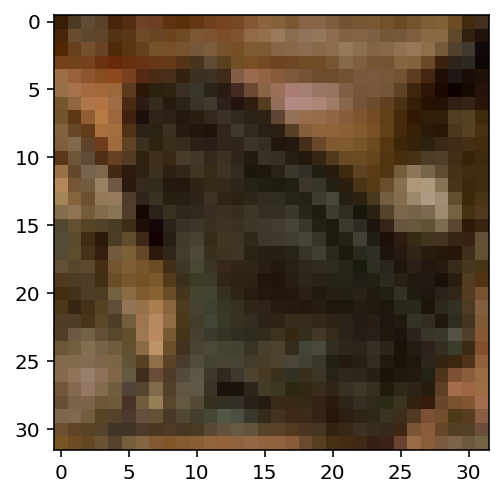

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import utils.p_utils 
from importlib import reload

utils.p_utils = reload(utils.p_utils)
from utils.p_utils import load_cfar10_batch, display_img

cifar10_dataset_file_path ='data/test/test_batch'
features, labels = load_cfar10_batch(cifar10_dataset_file_path)        

sample_id = 30
feature, label = display_img(features,labels, sample_id )



생성한 predictor에 입력 데이터를 넣어서 각 클래스(10개)의 Score 값을 가져오고, 여기서 가장 큰 값을 lable 로 예측 합니다.

In [30]:
import numpy as np

r_feature = feature[np.newaxis, :, :, :]
print("shape: ", r_feature.shape)

pred_response = predictor.predict(r_feature)
print(pred_response)
print("Predicted class is {}".format(np.argmax(pred_response['predictions'])))

shape:  (1, 32, 32, 3)
{'predictions': [[0.000682036858, 0.00256012846, 0.0670282, 0.355795801, 0.148625672, 0.149169877, 0.255726099, 0.0189486612, 0.000825191, 0.000638342404]]}
Predicted class is 3


## Cifar10 테스트 데이터 추론 예시 2


Example of Image 50:
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


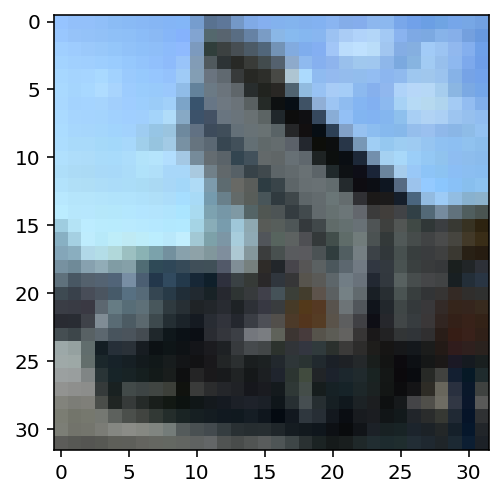

In [31]:
sample_id = 50
feature, label = display_img(features,labels, sample_id )



In [32]:
import numpy as np

r_feature = feature[np.newaxis, :, :, :]
print("shape: ", r_feature.shape)

pred_response = predictor.predict(r_feature)
print(pred_response)
print("Predicted class is {}".format(np.argmax(pred_response['predictions'])))

shape:  (1, 32, 32, 3)
{'predictions': [[0.0627915263, 0.169832915, 0.0690119, 0.108748749, 0.0613935515, 0.110146046, 0.0549058281, 0.134454831, 0.0481360853, 0.180578604]]}
Predicted class is 9


# 리소스 제거
본 워크샵에서 사용한 리소스에 대해 여러분의 AWS 계정에 과금되지 않도록 하려면 SageMaker Endpoint를 삭제해야 합니다.

In [33]:
# sagemaker_session.delete_endpoint(predictor.endpoint)